In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping 
from keras.wrappers.scikit_learn import KerasRegressor
import pickle

In [4]:
#read in data
df = pd.read_csv('data/hourly_nm.csv',index_col='Date/Time')
df.head()

,Power,Wind_speed,Theoretical_power,Loss,x_com,y_com,T_1
Date/Time,,,,,,,
2018-01-01 01:00:00,460.537125,5.644205,513.418408,52.881284,-1.068567,-5.515860,390.480362
2018-01-01 02:00:00,733.655375,6.452037,788.401310,54.745935,-0.176225,-6.440522,460.537125
2018-01-01 03:00:00,909.362081,6.811455,948.793346,39.431265,-1.652917,-6.596464,733.655375
2018-01-01 04:00:00,1393.518188,7.748749,1406.391795,12.873607,-2.912491,-7.138868,909.362081
2018-01-01 05:00:00,1149.599162,7.236854,1128.194441,-21.404721,-3.170687,-6.478943,1393.518188


In [5]:
print(df.info())
print()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 8759 entries, 2018-01-01 01:00:00 to 2018-12-31 23:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Power              8759 non-null   float64
 1   Wind_speed         8759 non-null   float64
 2   Theoretical_power  8759 non-null   float64
 3   Loss               8759 non-null   float64
 4   x_com              8759 non-null   float64
 5   y_com              8759 non-null   float64
 6   T_1                8759 non-null   float64
dtypes: float64(7)
memory usage: 547.4+ KB
None

             Power   Wind_speed  Theoretical_power         Loss        x_com  \
count  8759.000000  8759.000000        8759.000000  8759.000000  8759.000000   
mean   1318.141216     7.463044        1477.300912   159.159695     0.425291   
std    1272.154339     4.161819        1334.998877   316.032952     6.453773   
min      -0.179522     0.000000           0.000000  -342.198606  

In [6]:
#split data into training and testing, testing data will be one month
start_test = '2018-11-31'

train, test = df.loc[:start_test], df.loc[start_test:]

In [11]:
train.tail(1)

,Power,Wind_speed,Theoretical_power,Loss,x_com,y_com,T_1
Date/Time,,,,,,,
2018-11-30 23:00:00,87.315742,5.643659,516.885226,429.569483,3.995407,3.978305,231.796605


In [37]:
single_test_data = test.head(60)
single_test_data.head()

,Power,Wind_speed,Theoretical_power,Loss,x_com,y_com,T_1
Date/Time,,,,,,,
2018-12-01 00:00:00,280.210704,4.572140,281.809039,1.598335,-2.893603,-3.518642,87.315742
2018-12-01 01:00:00,10.587449,3.039396,27.387320,16.799871,-1.812171,-2.290541,280.210704
2018-12-01 02:00:00,0.000000,2.966449,9.344969,9.344969,-0.789323,-1.119788,10.587449
2018-12-01 03:00:00,36.122988,3.449081,68.554285,32.431296,-2.916623,-1.830116,0.000000
2018-12-01 04:00:00,29.878401,3.456015,66.375845,36.497444,-3.279210,-1.062822,36.122988


In [38]:
print(len(train))
print(len(test))
print(len(single_test_data))

8015
744
60


In [39]:
# scale the data using MinMax Scaler from -1 to 1 as LSTM has a default tanh activation function
SCALER = MinMaxScaler(feature_range=(-1,1))

scaler = SCALER.fit(train.to_numpy())

train_scaled = scaler.transform(train.to_numpy())
test_scaled = scaler.transform(test.to_numpy())
single_scaled = scaler.transform(single_test_data.to_numpy())

In [40]:
# create a function to split the datasets into two week windows
timestep = 24*7*2 # 24hours,7days,2weeks

def create_dataset(dataset, timestep=timestep):
    """
    Function which creates two week chunks of x_train data, and a single
    value for y_train.
    """
    X, y = [], []
    for i in range(len(dataset)):
        target_value = i + timestep
        if target_value == len(dataset):
            break
        feature_chunk, target = dataset[i:target_value, 1:], dataset[target_value, 0]
        X.append(feature_chunk)
        y.append(target)
    
    return np.array(X), np.array(y) 

In [41]:
#create x_train, y_train, X_test,y_test
X_train, y_train = create_dataset(train_scaled)
X_test, y_test = create_dataset(test_scaled)
X_single, y_single = create_dataset(single_scaled, timestep=1 * 30)

In [42]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_single.shape)
print(y_single.shape)

(7679, 336, 6)
(7679,)
(408, 336, 6)
(408,)
(30, 30, 6)
(30,)


In [43]:
# use sample of th data to train network to have a rough understanding of hyperparameters
samp_len = int(len(X_train)*0.5)
X_sample_train, y_sample_train = X_train[:samp_len], y_train[:samp_len]

In [44]:
print(X_sample_train.shape)
print(y_sample_train.shape)

(3839, 336, 6)
(3839,)


In [45]:
# create X_train, y_train, X_test, y_test datasets
# create a function to build a stacked LSTM model
# input needs to be [samples, timesteps, features]
def create_model(X_train, y_train):
    units = 32
    dropout = 0.05
    epochs = 35
    batch_size = 14
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    early_stopping = EarlyStopping(patience=7, monitor='loss')

    model = keras.Sequential()

    model.add(LSTM(units=units, dropout=dropout, return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
        
    model.add(LSTM(units=units, dropout=dropout))
        
    model.add(Dense(units=1))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    history = model.fit(X_train, y_train, validation_split=0.3, shuffle=False, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
       
    return model, history

In [47]:
# function to predict a single value 
def single_prediction(model, history, timestep=timestep):
        
        history = np.array(history)
        history = history.reshape(history.shape[0]*history.shape[1], history.shape[2])
        
        input_value = history[-timestep:]
        input_value = input_value.reshape(1, input_value.shape[0], input_value.shape[1])
        
        yhat = model.predict(input_value, verbose=0)
        return yhat

In [48]:
# function which takes first test chunk, makes a prediction, add the test chunk back into training data 
#to make next prediction

def walk_forward_prediction(X_train, y_train, X_test, timestep):
    
    MODEL, history = create_model(X_train=X_train, y_train=y_train)
    hist_train = [i for i in X_train]
    predictions = []
    
    for i in range(len(X_test)):
        test = X_test[i]
        yhat = single_prediction(model=MODEL, history=hist_train, timestep=timestep)
        predictions.append(yhat) 
        hist_train.append(test)
    
    return predictions, history, MODEL

In [49]:
def prior_inverse(features, targets):
    '''
    Append prediction value to test dataset and return a test shape format.
    '''
    dataset = []
    
    for i in range(features.shape[0]):
        last_row, target = features[i][0], targets[i]
        appended = np.append(last_row, target)
        dataset.append(appended)
    
    return np.array(dataset) 

In [50]:
#run experiemnt returning the real, predicted values
def experiment(X_train, y_train, X_test, timestep):
    
    pred_seq, history, MODEL = walk_forward_prediction(X_train, y_train, X_test, timestep)
    
    pred_seq = np.array(pred_seq).reshape(-1)

    pred = prior_inverse(X_test, pred_seq)
    real = prior_inverse(X_test, y_test)

    inv_pred = scaler.inverse_transform(pred)
    inv_real = scaler.inverse_transform(real)

    power_pred = inv_pred[:,-1]
    power_real = inv_real[:,-1]
    
    return power_real, power_pred, history, MODEL

In [ ]:
power_real, power_pred, history, MODEL = experiment(X_train, y_train, X_test, timestep)

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
#plot validation and training convergence graph
plt.figure(figsize=(10,5))
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('LSTM Training Validation Loss')
plt.tight_layout()
plt.savefig('figures/train_val_plot.png')
plt.show()

In [32]:
x_plot = test[timestep:].index
pred_df = pd.DataFrame({'Date':x_plot, 'Prediction': power_pred, 'True': power_real})
pred_df.set_index('Date', inplace=True)

In [33]:
pred_df2 = pred_df['2018-12-15 01:00:00	':'2018-12-29 02:00:00 ']

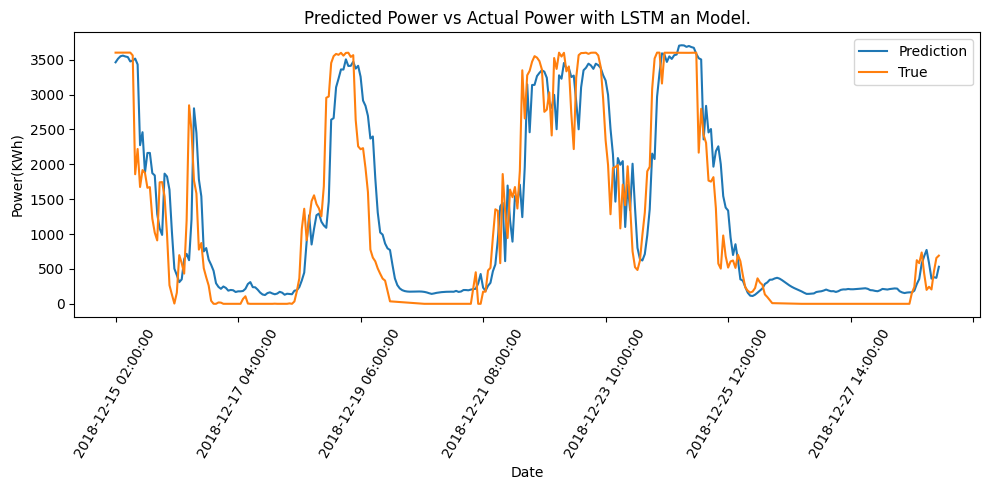

In [34]:
#plot predictions
pred_df2.plot(rot=60,figsize=(10,5))
plt.title('Predicted Power vs Actual Power with LSTM an Model.')
plt.ylabel('Power(KWh)')
plt.tight_layout()
plt.savefig('figures/prediction.png')
plt.show()

In [35]:
#compute metrics
rmse = np.sqrt(mean_squared_error(pred_df2['True'], pred_df2['Prediction']))
mae = mean_absolute_error(pred_df2['True'], pred_df2['Prediction'])
r2 = r2_score(pred_df2['True'], pred_df2['Prediction'])
print('RMSE: {}\nMAE: {}\nR2: {}'.format(round(rmse,2),round(mae,2), round(r2,2)))

RMSE: 525.37
MAE: 369.85
R2: 0.85


I decided to manually change the hyperparameters and record the results of the network to see the impact on the training and validation loss as well as making small adjustments to see the overall effect of the parameter.

In [36]:
results = {'Test':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],
           'sample_size':[0.25,0.25,0.25,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1,1,1,1,1,1,1,1,1],
           'units':[8,8,8,8,8,12,16,16,16,32,32,32,32,64,64,32,32,32,32,32,32,32],
           'layers':[2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2],
           'drop_out':[0.2,0.2,0.1,0.1,0.1,0.1,0.1,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05],
           'batch_size':[14,14,14,14,14,14,14,14,14,14,14,7,21,21,14,14,14,21,14,14,14,14],
           'learning_rate':[0.0001,0.0005,0.0005,0.0005,0.001,0.001,0.001,0.001,0.0005,0.0005,0.001,0.0005,0.0005,0.0005,0.0005,0.0005,0.001,0.0005,0.0005,0.0005,0.0005,0.0005],
           'epochs':[50,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,40,40,40,40,30,40],
           'RMSE':[689.87,603.55,577.52,525.36,507.46,484.93,478.51,477.91,489.13,476.17,478.19,487.14,479.56,535.83,497.55,487.31,498.46,535.63,496.71,493.76,496.2,496.35],
           'MAE':[544.42,509.95,476.48,381.44,370.11,342.71,343.28,348.48,332.21,334.14,344.09,349.62,336.19,394.55,343.45,320.26,328.72,389.17,337.31,334.41,338.35,342.69],
           'R2':['-','-','-','-','-','-','-','-',0.86,0.87,0.87,0.86,0.87,0.83,0.86,0.86,0.86,0.83,0.86,0.86,0.86,0.86]}

In [37]:
results_df = pd.DataFrame(data=results)
results_df

,Test,sample_size,units,layers,drop_out,batch_size,learning_rate,epochs,RMSE,MAE,R2
0,1,0.25,8,2,0.20,14,0.0001,50,689.87,544.42,-
1,2,0.25,8,2,0.20,14,0.0005,30,603.55,509.95,-
2,3,0.25,8,2,0.10,14,0.0005,30,577.52,476.48,-
3,4,0.50,8,2,0.10,14,0.0005,30,525.36,381.44,-
4,5,0.50,8,2,0.10,14,0.0010,30,507.46,370.11,-
5,6,0.50,12,2,0.10,14,0.0010,30,484.93,342.71,-
6,7,0.50,16,2,0.10,14,0.0010,30,478.51,343.28,-
7,8,0.50,16,2,0.05,14,0.0010,30,477.91,348.48,-
8,9,0.50,16,2,0.05,14,0.0005,30,489.13,332.21,0.86
9,10,0.50,32,2,0.05,14,0.0005,30,476.17,334.14,0.87


In [53]:
# Saves the trained model to models/ directory
MODEL.save(filepath='models/load_prediction_model_v1.h5')

In [54]:
# Loads saved model from models/ directory.
MODEL = load_model('models/load_prediction_model_v1.h5')

In [ ]:
# Saves keras history dict to pkl file in models/ directory
with open('models/history.pkl', 'wb') as hist_file:
    pickle.dump(history.history, hist_file)

In [ ]:
# Loads keras history dict from history.pkl file in models/ directory
with open('models/history.pkl', 'rb') as hist_file:
    loaded_hist = pickle.load(hist_file)
    print(loaded_hist)

In [17]:
# Saves processed training data array to x_train.pkl file in models/ directory
with open('models/x_test.pkl', 'wb') as inp:
    pickle.dump(X_test, inp)

In [18]:
# Loads processed training data array from x_train.pkl file in models/ directory
loaded_x_test = None
with open('models/x_test.pkl', 'rb') as inp:
    loaded_x_test = pickle.load(inp)
    loaded_x_test = np.array([loaded_x_test[0]])
    print(loaded_x_test.reshape(-1))
    print(loaded_x_test)

[-0.61492702 -0.84343942 -0.80800923 ... -0.43546783 -0.26037545
  0.80334225]
[[[-0.61492702 -0.84343942 -0.80800923  0.04677532 -0.25362188
   -0.95151514]
  [-0.74401722 -0.98478482 -0.79952004  0.10154316 -0.17289196
   -0.84448433]
  [-0.75016094 -0.99480835 -0.80368318  0.15334412 -0.09593183
   -0.99408904]
  ...
  [-0.02516038  0.9022623  -0.6610991  -0.35713024 -0.28242875
    0.40078403]
  [-0.01945323  0.89673043 -0.71724534 -0.37546167 -0.21995615
    0.75308059]
  [ 0.09031545  0.93503643 -0.77366257 -0.43546783 -0.26037545
    0.80334225]]]


In [33]:
# Function to compute a single prediction with test data
def test_single_prediction(model, history, timestep):
    pred_seq = single_prediction(model=model, history=history, timestep=timestep)

    pred_seq = np.array([pred_seq]).reshape(-1)

    pred = prior_inverse(np.array([X_test[0]]), pred_seq)

    inv_pred = scaler.inverse_transform(pred)

    return inv_pred[:,-1]
    

In [ ]:
def load_and_prep_testdata(filepath, timestep):
    test_data = pd.read_csv(filepath, index_col='Date/Time')
    SCALER = MinMaxScaler(feature_range=(-1,1))

    scaler = SCALER.fit(test_data.to_numpy())

    test_data_scaled = scaler(test_data.to_numpy())

    x_test, y_test = create_dataset(test_data_scaled)

    return x_test, y_test

In [56]:
# Calling test prediction function and presenting a single prediction
power_prediction = test_single_prediction(model=MODEL, history=X_single, timestep=30)
print('Predicted power for the given test data and a timestep of {0} hours, is {1} kW.'.format(timestep, power_prediction[0]))

Predicted power for the given test data and a timestep of 336 hours, is 517.5880482137267 kW.
